# Police Strategy Controls in Chicago for Crime

## Import packages

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [3]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

In [5]:
!wget -O chicago_crime.csv https://ibm.box.com/shared/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv

--2020-04-06 14:30:43--  https://ibm.box.com/shared/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197, 107.152.27.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv [following]
--2020-04-06 14:30:43--  https://ibm.box.com/public/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv [following]
--2020-04-06 14:30:43--  https://ibm.ent.box.com/public/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.26.211, 107.152.27.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.26.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: h

In [8]:
df = pd.read_csv('chicago_crime.csv')
df.head(1)

,ID,CASE_NUMBER,DATE,BLOCK,IUCR,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,...,WARD,COMMUNITY_AREA_NUMBER,FBICODE,X_COORDINATE,Y_COORDINATE,YEAR,UPDATEDON,LATITUDE,LONGITUDE,LOCATION
0,3512276,HK587712,08/28/2004 05:50:56 PM,047XX S KEDZIE AVE,890,THEFT,FROM BUILDING,SMALL RETAIL STORE,False,False,...,14.0,58.0,6,1155838.0,1873050.0,2004,02/10/2018 03:50:01 PM,41.807441,-87.703956,"(41.8074405, -87.703955849)"


In [7]:
df.shape

(533, 22)

In [19]:
df.drop(["BLOCK","BEAT","DISTRICT","UPDATEDON"],axis=1,inplace=True)

In [20]:
df.head()

,PRIMARY_TYPE,LOCATION_DESCRIPTION,ARREST,DOMESTIC,YEAR,LATITUDE,LONGITUDE,LOCATION
0,THEFT,SMALL RETAIL STORE,False,False,2004,41.807441,-87.703956,"(41.8074405, -87.703955849)"
1,THEFT,OTHER,False,False,2004,41.898280,-87.716406,"(41.898279962, -87.716405505)"
2,THEFT,NURSING HOME/RETIREMENT HOME,False,False,2011,41.815933,-87.624642,"(41.815933131, -87.624642127)"
3,THEFT,RESIDENCE,False,False,2010,41.743665,-87.562463,"(41.743665322, -87.562462756)"
4,THEFT,ALLEY,False,False,2016,41.773455,-87.706480,"(41.773455295, -87.706480471)"


In [42]:
df.groupby('ARREST')['LOCATION_DESCRIPTION'].count()

ARREST
False    370
True     163
Name: LOCATION_DESCRIPTION, dtype: int64

In [53]:
arrests = pd.DataFrame({"Status":["Arrested","Non arrested"],"Count":[163,370]})

In [54]:
arrests

,Status,Count
0,Arrested,163
1,Non arrested,370


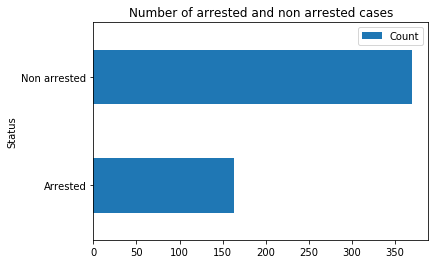

In [68]:
arrests.plot(kind='barh',title="Number of arrested and non arrested cases",x='Status',y='Count')

In [60]:
types = pd.DataFrame(df.groupby('PRIMARY_TYPE')['PRIMARY_TYPE'].count())

In [62]:
types.rename(columns={'PRIMARY_TYPE': 'Count'}, inplace=True)

In [67]:
#Filter types that have more than 30 cases

types = types[types.Count >= 30]
types

,Count
PRIMARY_TYPE,
ASSAULT,32
BATTERY,92
BURGLARY,30
CRIMINAL DAMAGE,58
NARCOTICS,54
OTHER OFFENSE,32
THEFT,106


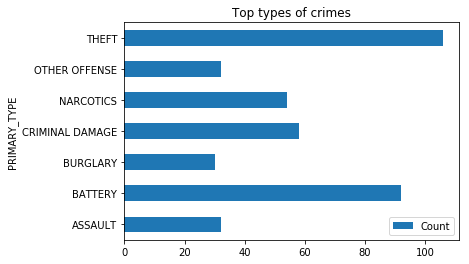

In [96]:
types.plot(kind='barh',title="Top types of crimes",y='Count')

In [89]:
location = pd.DataFrame(df.groupby('LOCATION_DESCRIPTION')['LOCATION_DESCRIPTION'].count())

In [91]:
location.rename(columns={'LOCATION_DESCRIPTION': 'Count'}, inplace=True)

In [92]:
location = location[location.Count >= 30]
location

,Count
LOCATION_DESCRIPTION,
APARTMENT,59
RESIDENCE,84
SIDEWALK,64
STREET,136


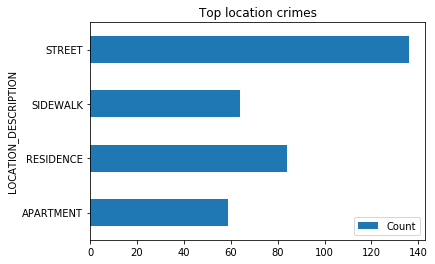

In [95]:
location.plot(kind='barh',title="Top location crimes",y='Count')

In [129]:
df.dropna(subset=['LOCATION'], inplace=True)
df.shape

(529, 8)

## Chicago map with all crimes

In [120]:
import folium
map_chicago = folium.Map(location=[41.850029, -87.6500473], zoom_start=10)

 # add markers to map
for lat, lng, primary_type in zip(df['LATITUDE'], df['LONGITUDE'], df['PRIMARY_TYPE']):
    label = '{}'.format(primary_type)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago) 
    
map_chicago

## But as we see, battery, narcotics, criminal damage and theft crimes are the most relevants

In [117]:
df_theft = df[df.PRIMARY_TYPE == "THEFT"]

In [119]:
map_chicagot = folium.Map(location=[41.850029, -87.6500473], zoom_start=10)

 # add markers to map
for lat, lng, primary_type in zip(df_theft['LATITUDE'], df_theft['LONGITUDE'], df_theft['PRIMARY_TYPE']):
    label = '{}'.format(primary_type)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicagot) 
    
map_chicagot

In [121]:
df_battery = df[df.PRIMARY_TYPE == "BATTERY"]

In [122]:
map_chicagob = folium.Map(location=[41.850029, -87.6500473], zoom_start=10)

 # add markers to map
for lat, lng, primary_type in zip(df_battery['LATITUDE'], df_battery['LONGITUDE'], df_battery['PRIMARY_TYPE']):
    label = '{}'.format(primary_type)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicagob) 
    
map_chicagob

In [123]:
df_narco = df[df.PRIMARY_TYPE == "NARCOTICS"]

In [125]:
map_chicagon = folium.Map(location=[41.850029, -87.6500473], zoom_start=10)

 # add markers to map
for lat, lng, primary_type in zip(df_narco['LATITUDE'], df_narco['LONGITUDE'], df_narco['PRIMARY_TYPE']):
    label = '{}'.format(primary_type)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicagon) 
    
map_chicagon

In [126]:
df_cd = df[df.PRIMARY_TYPE == "CRIMINAL DAMAGE"]

In [130]:
map_chicagocd = folium.Map(location=[41.850029, -87.6500473], zoom_start=10)

 # add markers to map
for lat, lng, primary_type in zip(df_cd['LATITUDE'], df_cd['LONGITUDE'], df_cd['PRIMARY_TYPE']):
    label = '{}'.format(primary_type)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicagocd) 
    
map_chicagocd